In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
from PIL import Image

#warnings
import warnings
warnings.filterwarnings("ignore")

# Libraries for TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa
from keras import models, layers
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50
from keras.applications import Xception
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix


print("Importing libraries completed.")

Importing libraries completed.


In [5]:
data_dir = r"C:\Users\Ven\Desktop\Cash-Counterfeat\model\data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [6]:
# acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['fake_1k', 'fake_500', 'real_1k', 'real_500']


In [7]:
HEIGHT = 300
WIDTH = 400
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 50

n_classes = len(class_names)
n_classes

4

In [8]:
img_size = (HEIGHT, WIDTH)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 800 images belonging to 4 classes.


Found 200 images belonging to 4 classes.


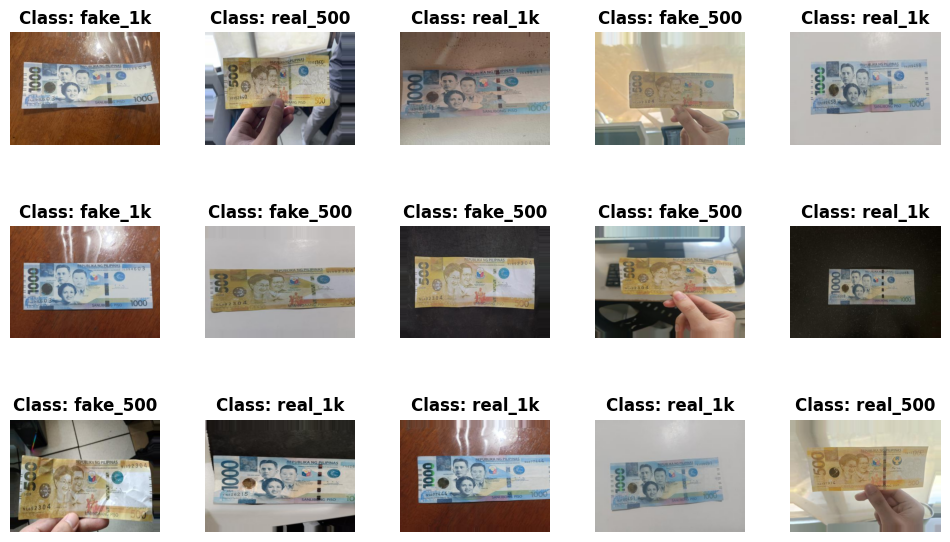

In [7]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    
    # Get the class index from one-hot encoded target
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]
    
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [8]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

In [9]:
from keras.applications import MobileNetV2
from keras import layers, models
from keras.regularizers import l2

# MobileNetV2
input_layer = layers.Input(shape=(HEIGHT, WIDTH, CHANNELS))

model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)

x = model_mobilenetv2.output
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling instead of Flatten
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.3)(x)  # Add dropout
output_layer = layers.Dense(n_classes, activation='softmax')(x)

model_mobilenetv2 = models.Model(inputs=model_mobilenetv2.input, outputs=output_layer)

print("We are making all the layers untrainable except the last layer.\n")
for layer in model_mobilenetv2.layers[:-1]:
    layer.trainable = False

We are making all the layers untrainable except the last layer.



In [10]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb]

In [11]:
model_mobilenetv2.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model_mobilenetv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 200, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 200, 32  128         ['Conv1[0][0]']                  
                                )                                                             

                                )                                                                 
                                                                                                  
 block_2_expand_BN (BatchNormal  (None, 75, 100, 144  576        ['block_2_expand[0][0]']         
 ization)                       )                                                                 
                                                                                                  
 block_2_expand_relu (ReLU)     (None, 75, 100, 144  0           ['block_2_expand_BN[0][0]']      
                                )                                                                 
                                                                                                  
 block_2_depthwise (DepthwiseCo  (None, 75, 100, 144  1296       ['block_2_expand_relu[0][0]']    
 nv2D)                          )                                                                 
          

In [12]:
history_vgg = model_mobilenetv2.fit(train_generator,batch_size=BATCH_SIZE,verbose=True,validation_data=test_generator, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
50/50 [==============================] - 46s 611ms/step - loss: 2.0096 - acc: 0.4137 - f1_score: 0.4121 - val_loss: 1.8709 - val_acc: 0.6000 - val_f1_score: 0.5896 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 27s 531ms/step - loss: 1.8434 - acc: 0.5150 - f1_score: 0.5138 - val_loss: 1.7224 - val_acc: 0.7100 - val_f1_score: 0.7026 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 27s 535ms/step - loss: 1.6986 - acc: 0.6388 - f1_score: 0.6381 - val_loss: 1.5799 - val_acc: 0.7900 - val_f1_score: 0.7885 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 27s 533ms/step - loss: 1.5820 - acc: 0.6888 - f1_score: 0.6883 - val_loss: 1.4989 - val_acc: 0.8000 - val_f1_score: 0.8007 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 27s 529ms/step - loss: 1.5157 - acc: 0.7412 - f1_score: 0.7407 - val_loss: 1.4200 - val_acc: 0.8200 - val_f1_score: 0.8183 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 26s 525m

In [ ]:
from tensorflow.keras.models import model_from_json
# Load model architecture from JSON file
model_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetV2\mobnetv2_model.json"
with open(model_path, 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# Load model weights
weights_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetV2\weights\mobnetv2.hdf5"
model.load_weights(weights_path)

model.summary()

In [13]:
predictions = model_mobilenetv2.predict(test_generator)

# Obtain the true labels from the test_generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

13/13 [==============================] - 2s 85ms/step
              precision    recall  f1-score   support

     fake_1k       0.89      0.98      0.93        50
    fake_500       0.98      0.98      0.98        50
     real_1k       0.98      0.88      0.93        50
    real_500       0.98      0.98      0.98        50

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



In [54]:
sns.set(style="whitegrid", rc={"axes.grid": True})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
# plt.savefig('../../server/vgg16/metrics/training')

plt.show()

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1, 2, 3], labels=class_names)
plt.yticks(ticks=[0, 1, 2, 3], labels=class_names)
plt.show()

In [14]:
# Save the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenetv2)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetV2\tflite\mobnetV3.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Ven\AppData\Local\Temp\tmpk1xw7ive\assets


INFO:tensorflow:Assets written to: C:\Users\Ven\AppData\Local\Temp\tmpk1xw7ive\assets


In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load the TFLite model
tflite_model_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetV2\tflite\mobnetV3.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to predict using the TFLite model
def predict_tflite(image_data):
    interpreter.set_tensor(input_details[0]['index'], image_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

In [33]:
# Run predictions on the test data
predicted_labels = []
true_labels = []

for images, labels in test_generator:
    for image, label in zip(images, labels):
        # Prepare image data for prediction
        image_data = np.expand_dims(image, axis=0)

        # Get prediction from TFLite model
        output = predict_tflite(image_data)

        # Get predicted and true labels
        predicted_label = np.argmax(output)
        true_label = np.argmax(label)

        predicted_labels.append(predicted_label)
        true_labels.append(true_label)

    if len(predicted_labels) >= len(test_generator.classes):
        break

In [34]:
# Classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     fake_1k       0.89      0.98      0.93        50
    fake_500       0.98      0.98      0.98        50
     real_1k       0.98      0.88      0.93        50
    real_500       0.98      0.98      0.98        50

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



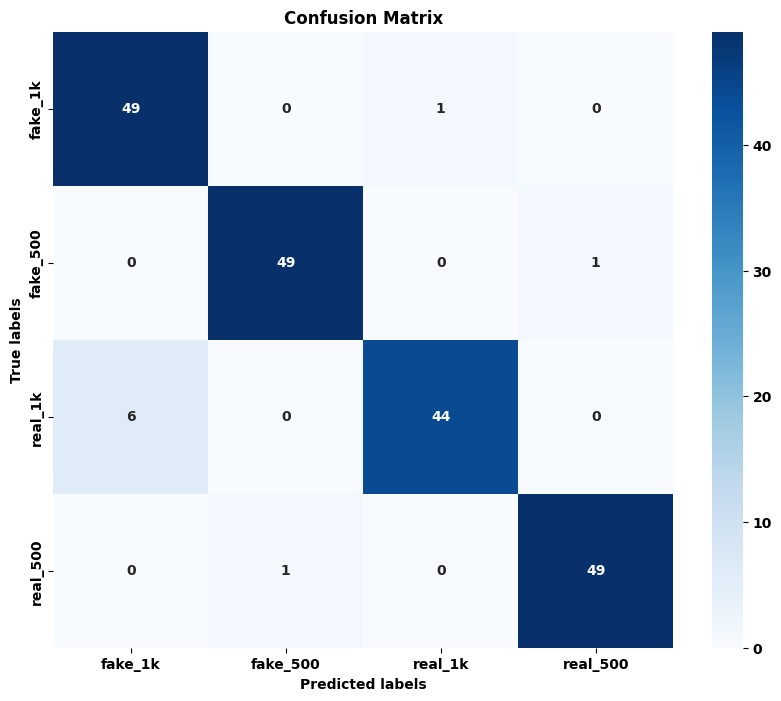

In [35]:
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [77]:
from PIL import Image, ImageOps

# Function to preprocess image
# def preprocess_image(image_path, target_size):
#     img = Image.open(image_path)
#     img = img.resize(target_size)
#     img_array = np.array(img)
#     img_array = img_array.astype('float32') / 255.0
#     img_array = np.expand_dims(img_array, axis=0)
#     return img_array

def preprocess_image(image_path, target_size, flip_upside_down=False):
    img = Image.open(image_path)
    img = img.resize(target_size)
    if flip_upside_down:
        img = ImageOps.flip(img)
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict using the TFLite model
def predict_tflite(image_data):
    interpreter.set_tensor(input_details[0]['index'], image_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data


In [104]:
# Sample image path
sample_image_path = r"C:\Users\Ven\Desktop\CashCF Data\Raw Data\real_500\IMG20240419123522.jpg"
# Preprocess the sample image
input_image = preprocess_image(sample_image_path, target_size=(WIDTH, HEIGHT), flip_upside_down=False)

# Get prediction from TFLite model
output = predict_tflite(input_image)

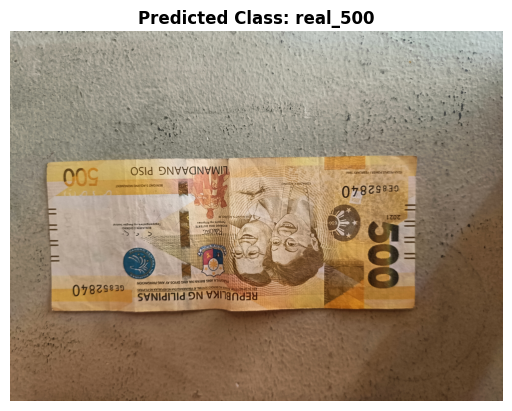

In [105]:
# Get the predicted class index
predicted_class_index = np.argmax(output)

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Show the sample image with the predicted class
plt.imshow(plt.imread(sample_image_path))
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')
plt.show()